
# Forced Alignment with Wav2Vec2



In [1]:
import os
data_path = './data/ST-CMDS-20170001_1-OS/'
files = os.listdir(data_path)
file_names = []
for file in files:
    if file.split('.')[1] == 'txt':
        file_names.append(file.split('.')[0])
dataset_file_num = len(file_names)
dataset_file_num

102600

In [2]:
get_audio = lambda x: data_path+file_names[x]+'.wav' if x < dataset_file_num else None
get_text = lambda x: open(data_path+file_names[x]+'.txt', "r").read() if x < dataset_file_num else None

In [4]:
# fix Audio for vscode notebook
def Audio(path):
    os.popen(f'cp {path} ./audio-temp.wav') 
    print('please check ./audio-temp.wav for audio')

In [5]:
import random
# from IPython.display import Audio

rand_id = 963 # random.randint(0, dataset_file_num-1)

audio_file = get_audio(rand_id)

sentence = get_text(rand_id)

print(rand_id, sentence)
Audio(audio_file)

963 威
please check ./audio-temp.wav for audio


## Preparation

First we import the necessary packages, and fetch data that we work on.




In [6]:
# %matplotlib inline

import os
from dataclasses import dataclass

import IPython
import matplotlib
import matplotlib.pyplot as plt
import requests
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F

matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", exist_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)
Audio(SPEECH_FILE)

1.11.0
0.11.0
cpu
please check ./audio-temp.wav for audio


## Generate frame-wise label probability

The first step is to generate the label class porbability of each aduio
frame. We can use a Wav2Vec2 model that is trained for ASR. Here we use
:py:func:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H`.

``torchaudio`` provides easy access to pretrained models with associated
labels.

<div class="alert alert-info"><h4>Note</h4><p>In the subsequent sections, we will compute the probability in
   log-domain to avoid numerical instability. For this purpose, we
   normalize the ``emission`` with :py:func:`torch.log_softmax`.</p></div>




In [34]:
bundle = torchaudio.pipelines.VOXPOPULI_ASR_BASE_10K_EN
wave2vec_model = bundle.get_model().to(device)
labels = bundle.get_labels()

wave2vec_model.aux

Linear(in_features=768, out_features=28, bias=True)

In [8]:
# model

In [35]:
k = wave2vec_model.feature_extractor.conv_layers[0].conv.kernel_size[0]

In [36]:

with torch.inference_mode():
    waveform, _ = torchaudio.load(SPEECH_FILE)
    print(waveform.shape)
    emissions, _ = wave2vec_model(waveform.to(device))
    emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

torch.Size([1, 54400])


In [11]:
emission.shape

torch.Size([169, 28])

## Do CTC Decoder

In [12]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

class NaiveCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        # indices = torch.unique_consecutive(indices, dim=-1)
        # indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [53]:
from utils.helper import get_labels

labels = get_labels()
look_up = {s: i for i, s in enumerate(labels)} # 字母转数字

In [55]:
print("labels", labels)

labels ('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z')


# Transfer Learning in Chinese

In [16]:
# ! pip install pypinyin

创建中文注音label，不要让模型直接预测拼音，而是改为预测音素

In [59]:
print(labels, len(labels))

('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z') 28


In [19]:
decoder = GreedyCTCDecoder(labels=labels)

In [20]:
import pypinyin
from pypinyin import lazy_pinyin, Style

In [60]:
lazy_pinyin('林允儿嗯', strict=True, style=Style.INITIALS, errors=lambda x: u'-'),\
    lazy_pinyin('林云儿嗯', strict=True, style=Style.FINALS, errors=lambda x: u'-')

(['l', '', '', ''], ['in', 'vn', 'er', ''])

In [61]:
# def chinese2pinyin(text):
#     initials = lazy_pinyin(text, strict=True, style=Style.INITIALS, errors=lambda x: u'')
#     finals = lazy_pinyin(text, strict=True, style=Style.FINALS, errors=lambda x: u'')
#     pinyin = ''
#     for i in range(len(finals)):
#         pinyin+='|'
#         if (initials[i] == '-'):
#             continue
#         pinyin+=initials[i]
#         pinyin+=finals[i]
#         if finals[i] == '':
#             pinyin+='n'
#     if pinyin[-1] == '|':
#         pinyin = pinyin[:-1]
#     return pinyin[1:].lower().replace('w','u')

def chinese2pinyin(text):
    pinyin = lazy_pinyin(text, strict=True,errors=lambda x: u'')
    pinyin = [i for i in '|'.join(pinyin)]
    return pinyin

''.join(chinese2pinyin("绿色的温水，迂回的乌烟，流过。啊！哇！嗯，问妞儿归去."))

'lv|se|de|wen|shui|yu|hui|de|wu|yan|liu|guo|a|wa|n|wen|niu|er|gui|qu'

In [62]:
def label2id(str):
    return [look_up[i] for i in str]

def id2label(idcs):
    return [labels[i] for i in idcs]

# label2id(chinese2pinyin("美好，我很开心儿！")), ','.join(id2label(label2id(chinese2pinyin("美好，我很开心！"))))

In [63]:
from torch.utils.data import Dataset, DataLoader, default_collate

In [67]:
from utils.dataset import AudioDataset, LoaderGenerator

In [68]:
dataset = AudioDataset('./data/ST-CMDS-20170001_1-OS/')
batch_size = 8
train_set, test_set = dataset.split([1000, 5])
k_size = wave2vec_model.feature_extractor.conv_layers[0].conv.kernel_size[0] # kernel size for audio encoder
loaderGenerator = LoaderGenerator(labels, chinese2pinyin, k_size)
train_loader = loaderGenerator.dataloader(train_set, batch_size)
test_loader = loaderGenerator.dataloader(test_set, batch_size) # without backprop, can use larger batch
print('train_set:', len(train_set), 'test_set:',len(test_set))

train_set: 102089 test_set: 511


In [69]:
for i_batch, sample_batched in enumerate(test_loader):
    print(sample_batched['audio'].shape, sample_batched['target'].shape)
    # for i in sample_batched['audio']:
    #     print(i.shape)
    break

torch.Size([8, 87178]) torch.Size([8, 56])


In [70]:
o, l = wave2vec_model(sample_batched['audio'], sample_batched['audio_len'])
o.shape, l.shape

(torch.Size([8, 272, 28]), torch.Size([8]))

In [71]:
emissions = torch.log_softmax(o, dim=-1)
transcript = decoder(emissions[2])
transcript

'cind|dea|whoni|on|year|hind|our|toms|yr|who|otsinceta'

In [32]:
ctc_loss = torch.nn.CTCLoss(zero_infinity=True)
print(emissions.shape, sample_batched['target'].shape, l.shape, sample_batched['target_len'].shape)
loss = ctc_loss(emissions.permute(1,0,2), sample_batched['target'], l, sample_batched['target_len'])
loss

torch.Size([8, 229, 28]) torch.Size([8, 60]) torch.Size([8]) torch.Size([8])


tensor(2.6494, grad_fn=<MeanBackward0>)

In [72]:
# model = bundle.get_model()
# for param in model.parameters():
#     param.requires_grad = False
# # model.aux = torch.nn.Linear(in_features=model.aux.in_features, out_features=model.aux.out_features, bias=True)
# # torch.nn.init.xavier_normal(model.aux.weight)
# for param in model.aux.parameters():
#     param.requires_grad = True
# model = model.to(device)

class ChineseStt(torch.nn.Module):
    def __init__(self, wave2vec_model, out_features):
        super(ChineseStt, self).__init__()
        self.feature_extractor = wave2vec_model.feature_extractor
        self.encoder = wave2vec_model.encoder
        in_features = wave2vec_model.encoder.transformer.layers[-1].final_layer_norm.normalized_shape[0]
        self.aux = nn.Linear(in_features, out_features, bias=True)

    def forward(self, x, lengths=None):
        x, lengths = self.feature_extractor(x, lengths)
        x = self.encoder(x, lengths)
        x = self.aux(x)
        return x, lengths

In [73]:
# with torch.no_grad():
#     i = 2
#     sample = audio_dataset[i]
#     print(i, sample['audio'].shape, sample['text'])

#     waveform = sample['audio']
#     emissions, _ = model(waveform.to(device))
#     emissions = torch.log_softmax(emissions, dim=-1).permute(1, 0, 2)

#     ctc_loss = torch.nn.CTCLoss(zero_infinity=True)
#     target = torch.tensor([label2id(chinese2pinyin(sample['text']))])
#     # target = 
#     print(emissions.shape, target.shape)
#     Input_lengths = (emissions.shape[0],)
#     Target_lengths = (target.shape[-1],)
#     loss = ctc_loss(emissions, target, Input_lengths, Target_lengths)

# emission = emissions.cpu().detach()
# transcript = decoder(emission)
# transcript, ','.join(chinese2pinyin(sample['text'])), loss.item()

In [74]:
# chinese2pinyin(sample['text'])

In [75]:
# id = label2id(chinese2pinyin(sample['text']))
# len(id),print(id)

In [76]:
# len(audio_dataset)

In [44]:
# model

In [81]:
model = ChineseStt(wave2vec_model, len(labels))
for param in model.feature_extractor.parameters():
    param.requires_grad = False
torch.nn.init.xavier_normal_(model.aux.weight)
for param in model.encoder.parameters():
    param.requires_grad = True
params = list(model.aux.parameters())+list(model.encoder.parameters())
# params = model.aux.parameters()
model = model.to(device)

In [78]:
# optimizer = torch.optim.SGD(model.aux.parameters(), lr=0.01, momentum=0.9)
# optimizer = torch.optim.Adam(model.aux.parameters(), lr=0.01)
optimizer = torch.optim.SGD(model.aux.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Try to save checkpoint

In [82]:
from os.path import exists
LOAD_PATH = './checkpoint/model_temp.pt'
def load_checkpoint(path):
    if exists(path):
        print('file',path,'exist, load checkpoint...')
        checkpoint = torch.load(path, map_location=device)
        if 'model_state_dict' in checkpoint:
            model.aux.load_state_dict(checkpoint['model_state_dict'])
        if 'model_encoder_dict' in checkpoint:
            model.encoder.load_state_dict(checkpoint['model_encoder_dict'])
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        print(epoch, loss)
load_checkpoint(LOAD_PATH)

file ./checkpoint/model_temp.pt exist, load checkpoint...
-1 tensor(0.2292, requires_grad=True)


In [83]:
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
ctc_loss = torch.nn.CTCLoss(zero_infinity=True)

In [84]:
def test(k):
    model.eval()
    with torch.no_grad():
        for i in range(k):
            sample = test_set[i]
            print(i, sample['audio'].shape, sample['text'])
            waveform = sample['audio']
            emissions, _ = model(waveform.to(device))
            emissions = torch.log_softmax(emissions, dim=-1)
            emission = emissions[0].cpu().detach()
            transcript = decoder(emission)
            print('transcript:', transcript, NaiveCTCDecoder(labels)(emission))

In [218]:
def save_checkpoint(EPOCH, LOSS):
    PATH = f"./checkpoint/model_{EPOCH}_{LOSS}.pt"
    torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.aux.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [51]:
def train():
    for epoch in range(1):
        model.train()
        current_loss = 0
        for i_batch, sample_batched in enumerate(dataloader):
            batch_loss = 0
            optimizer.zero_grad()
            # for i in range(batch_size):  # Cannot run in batch, only 1 by 1
                
            # Step 1. Prepare Data
            waveform = sample_batched['audio']
            wave_len = sample_batched['audio_len']
            target = sample_batched['target']
            target_len = sample_batched['target_len']

            # Step 2. Run our forward pass
            emissions, emission_len = model(waveform, wave_len)
            # emissions, _ = model(waveform.to(device))
            emissions = torch.nn.functional.log_softmax(emissions, dim=-1).permute(1,0,2)
            # target = torch.tensor([target]).to(device)
            loss = ctc_loss(emissions, target, emission_len, target_len)

            # Step 2. Run our backward pass
            loss.backward()
            
            if loss.item()!=loss.item():
                print('NaN hit!')
                exit()
            current_loss += loss.item()
            batch_loss += loss.item()

            optimizer.step()
            if i_batch % (2000 // batch_size) == 0:
                # print('epoch', epoch, 'lr', scheduler.get_lr(), 'loss', batch_loss/batch_size)
                save_log(f'e{epoch}.txt', ['epoch', epoch, 'lr', scheduler.get_last_lr(), 'loss', batch_loss/batch_size])
                test(epoch, 5)
            
        # scheduler.step()
        save_checkpoint(epoch, current_loss/len(dataloader.dataset))
        test(epoch, 10) # run some sample prediction and see the result

# train()

In [86]:
with torch.no_grad():
    i = 0
    sample = test_set[i]
    Audio(get_audio(i))
    print(i, sample['audio'].shape, sample['text'])

    waveform = sample['audio']
    # waveform, sample_rate = torchaudio.load('./_assets/t3.wav')
    # waveform = torchaudio.functional.resample(waveform, sample_rate, sr)
    emissions_org, _ = model(waveform.to(device))
    emissions = torch.log_softmax(emissions_org, dim=-1)

emission = emissions[0].cpu().detach()
transcript = decoder(emission)
transcript, NaiveCTCDecoder(labels)(emission)

please check ./audio-temp.wav for audio
0 torch.Size([1, 65968]) 我们准星期天约起克烧烤勒


('wo|men|zhun|xing|qi|tian|yue|qi|ke|shao|kao|lei',
 '---------------------------------------wo----||mennn--||zhuunn---||x-inngg-||q--i---||t-ii--aan---||yuue-----||q--i-----|||k-e----||sh-aoo---||k--aoo--||l--eii----------------------------------------------')

### Visualization



('-', '|', 'e', 't', 'o', 'i', 'a', 'n', 's', 'r', 'h', 'l', 'd', 'c', 'u', 'm', 'p', 'f', 'g', 'w', 'y', 'b', 'v', 'k', 'x', 'j', 'q', 'z')


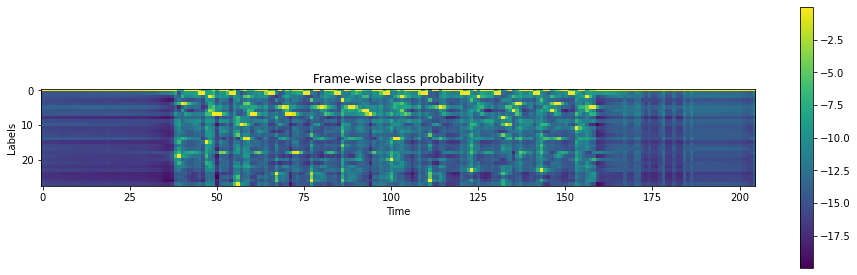

In [87]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [88]:
transcript = transcript
dictionary = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))


def get_trellis(emission, tokens, blank_id=0):
    num_frame = emission.size(0)
    num_tokens = len(tokens)

    # Trellis has extra diemsions for both time axis and tokens.
    # The extra dim for tokens represents <SoS> (start-of-sentence)
    # The extra dim for time axis is for simplification of the code.
    trellis = torch.full((num_frame + 1, num_tokens + 1), -float("inf"))
    trellis[:, 0] = 0
    for t in range(num_frame):
        trellis[t + 1, 1:] = torch.maximum(
            # Score for staying at the same token
            trellis[t, 1:] + emission[t, blank_id],
            # Score for changing to the next token
            trellis[t, :-1] + emission[t, tokens],
        )
    return trellis


trellis = get_trellis(emission, tokens)

[('w', 19), ('o', 4), ('|', 1), ('m', 15), ('e', 2), ('n', 7), ('|', 1), ('z', 27), ('h', 10), ('u', 14), ('n', 7), ('|', 1), ('x', 24), ('i', 5), ('n', 7), ('g', 18), ('|', 1), ('q', 26), ('i', 5), ('|', 1), ('t', 3), ('i', 5), ('a', 6), ('n', 7), ('|', 1), ('y', 20), ('u', 14), ('e', 2), ('|', 1), ('q', 26), ('i', 5), ('|', 1), ('k', 23), ('e', 2), ('|', 1), ('s', 8), ('h', 10), ('a', 6), ('o', 4), ('|', 1), ('k', 23), ('a', 6), ('o', 4), ('|', 1), ('l', 11), ('e', 2), ('i', 5)]


In [89]:
NaiveCTCDecoder(labels)(emission)

'---------------------------------------wo----||mennn--||zhuunn---||x-inngg-||q--i---||t-ii--aan---||yuue-----||q--i-----|||k-e----||sh-aoo---||k--aoo--||l--eii----------------------------------------------'

In [90]:
emissions_org[:,0]

tensor([[14.9373,  0.1133,  0.1590, -0.1610, -0.2751,  1.2146,  0.3598,  0.3131,
         -1.8640, -0.1544,  0.9459, -0.9797, -0.4989, -0.2222,  0.6553, -1.6033,
         -0.4222, -0.2284, -1.1644, -0.5645, -0.8655, -0.5716, -1.5488, -0.7369,
         -2.1012, -1.9985, -1.4473, -0.7816]])

In [91]:
class ChineseDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        # indices = torch.unique_consecutive(indices, dim=-1)
        # indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

ChineseDecoder(labels)(emission)

'---------------------------------------wo----||mennn--||zhuunn---||x-inngg-||q--i---||t-ii--aan---||yuue-----||q--i-----|||k-e----||sh-aoo---||k--aoo--||l--eii----------------------------------------------'

### Visualization



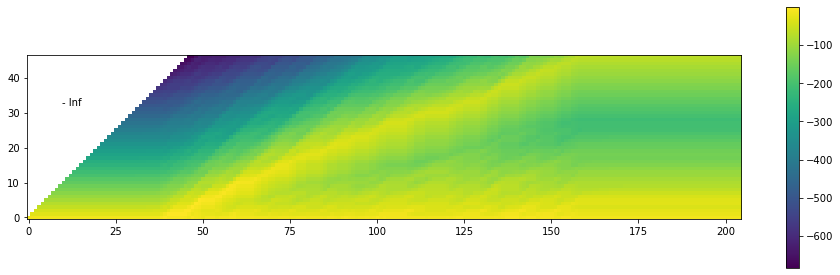

In [92]:
plt.imshow(trellis[1:, 1:].T, origin="lower")
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In the above visualization, we can see that there is a trace of high
probability crossing the matrix diagonally.




## Find the most likely path (backtracking)

Once the trellis is generated, we will traverse it following the
elements with high probability.

We will start from the last label index with the time step of highest
probability, then, we traverse back in time, picking stay
($c_j \rightarrow c_j$) or transition
($c_j \rightarrow c_{j+1}$), based on the post-transition
probability $k_{t, j} p(t+1, c_{j+1})$ or
$k_{t, j+1} p(t+1, repeat)$.

Transition is done once the label reaches the beginning.

The trellis matrix is used for path-finding, but for the final
probability of each segment, we take the frame-wise probability from
emission matrix.




In [93]:
@dataclass
class Point:
    token_index: int
    time_index: int
    score: float


def backtrack(trellis, emission, tokens, blank_id=0):
    # Note:
    # j and t are indices for trellis, which has extra dimensions
    # for time and tokens at the beginning.
    # When referring to time frame index `T` in trellis,
    # the corresponding index in emission is `T-1`.
    # Similarly, when referring to token index `J` in trellis,
    # the corresponding index in transcript is `J-1`.
    j = trellis.size(1) - 1
    t_start = torch.argmax(trellis[:, j]).item()

    path = []
    for t in range(t_start, 0, -1):
        # 1. Figure out if the current position was stay or change
        # Note (again):
        # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
        # Score for token staying the same from time frame J-1 to T.
        stayed = trellis[t - 1, j] + emission[t - 1, blank_id]
        # Score for token changing from C-1 at T-1 to J at T.
        changed = trellis[t - 1, j - 1] + emission[t - 1, tokens[j - 1]]

        # 2. Store the path with frame-wise probability.
        prob = emission[t - 1, tokens[j - 1] if changed > stayed else 0].exp().item()
        # Return token index and time index in non-trellis coordinate.
        path.append(Point(j - 1, t - 1, prob))

        # 3. Update the token
        if changed > stayed:
            j -= 1
            if j == 0:
                break
    else:
        raise ValueError("Failed to align")
    return path[::-1]


path = backtrack(trellis, emission, tokens)
# print(path)

### Visualization



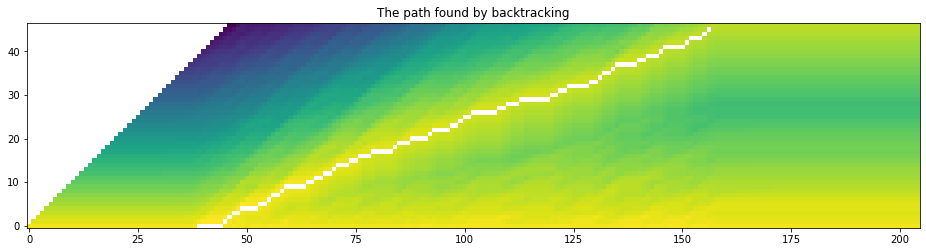

In [94]:
def plot_trellis_with_path(trellis, path):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    for _, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float("nan")
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")


plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

Looking good. Now this path contains repetations for the same labels, so
let’s merge them to make it close to the original transcript.

When merging the multiple path points, we simply take the average
probability for the merged segments.




In [95]:
# Merge the labels
@dataclass
class Segment:
    label: str
    start: int
    end: int
    score: float

    def __repr__(self):
        return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

    @property
    def length(self):
        return self.end - self.start


def merge_repeats(path):
    i1, i2 = 0, 0
    segments = []
    while i1 < len(path):
        while i2 < len(path) and path[i1].token_index == path[i2].token_index:
            i2 += 1
        score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
        segments.append(
            Segment(
                transcript[path[i1].token_index],
                path[i1].time_index,
                path[i2 - 1].time_index + 1,
                score,
            )
        )
        i1 = i2
    return segments


segments = merge_repeats(path)
for seg in segments:
    print(seg)

w	(0.99): [   39,    40)
o	(0.82): [   40,    46)
|	(1.00): [   46,    47)
m	(0.99): [   47,    48)
e	(0.53): [   48,    50)
n	(0.84): [   50,    54)
|	(0.54): [   54,    56)
z	(0.98): [   56,    57)
h	(0.62): [   57,    59)
u	(0.96): [   59,    60)
n	(0.80): [   60,    65)
|	(0.50): [   65,    67)
x	(0.99): [   67,    69)
i	(0.53): [   69,    71)
n	(1.00): [   71,    72)
g	(0.61): [   72,    75)
|	(0.50): [   75,    77)
q	(0.92): [   77,    80)
i	(0.80): [   80,    85)
|	(1.00): [   85,    86)
t	(0.70): [   86,    89)
i	(0.75): [   89,    93)
a	(0.95): [   93,    94)
n	(1.00): [   94,    98)
|	(0.58): [   98,   100)
y	(0.99): [  100,   101)
u	(0.69): [  101,   103)
e	(0.98): [  103,   109)
|	(0.56): [  109,   111)
q	(0.99): [  111,   114)
i	(0.91): [  114,   121)
|	(0.51): [  121,   123)
k	(0.99): [  123,   125)
e	(1.00): [  125,   130)
|	(0.54): [  130,   132)
s	(0.98): [  132,   133)
h	(0.97): [  133,   135)
a	(1.00): [  135,   136)
o	(0.89): [  136,   141)
|	(0.51): [  141,   143)


### Visualization



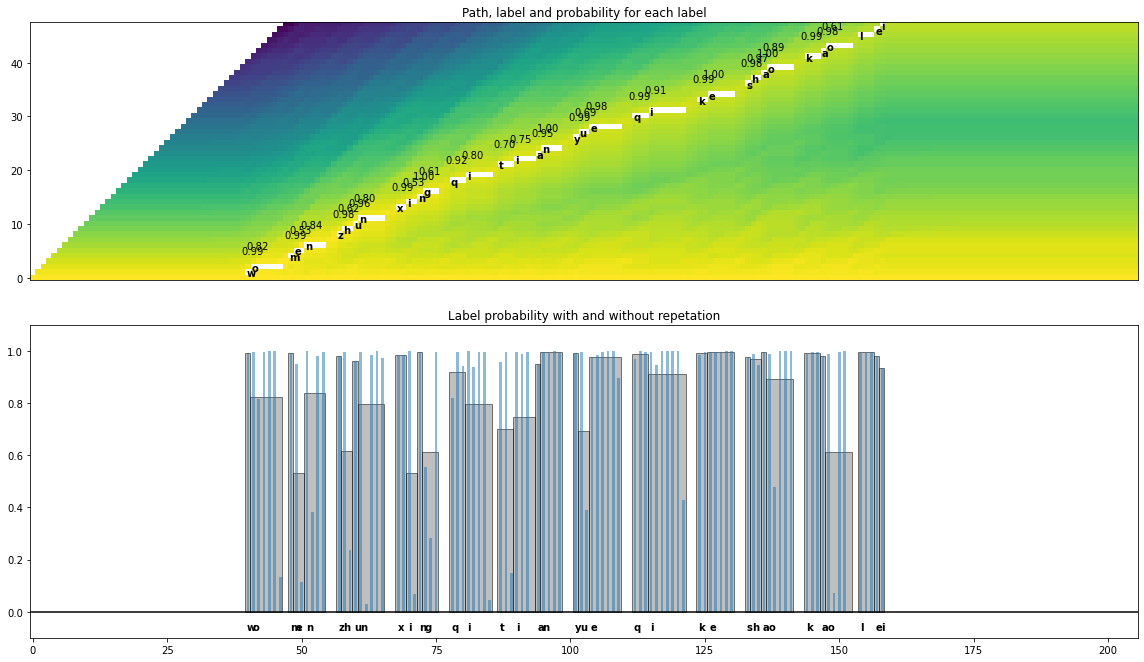

In [96]:
def plot_trellis_with_segments(trellis, segments, transcript):
    # To plot trellis with path, we take advantage of 'nan' value
    trellis_with_path = trellis.clone()
    
    for i, seg in enumerate(segments):
        # if seg.label == '|':
        #     seg.label = ","
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")
        

    fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
    ax1.set_title("Path, label and probability for each label")
    ax1.imshow(trellis_with_path.T, origin="lower")
    ax1.set_xticks([])

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start + 0.7, i + 0.3), weight="bold")
            ax1.annotate(f"{seg.score:.2f}", (seg.start - 0.3, i + 4.3))

    ax2.set_title("Label probability with and without repetation")
    xs, hs, ws = [], [], []
    for seg in segments:
        if seg.label != "|":
            xs.append((seg.end + seg.start) / 2 + 0.4)
            hs.append(seg.score)
            ws.append(seg.end - seg.start)
            ax2.annotate(seg.label, (seg.start + 0.8, -0.07), weight="bold")
    ax2.bar(xs, hs, width=ws, color="gray", alpha=0.5, edgecolor="black")

    xs, hs = [], []
    for p in path:
        label = transcript[p.token_index]
        if label != "|":
            xs.append(p.time_index + 1)
            hs.append(p.score)

    ax2.bar(xs, hs, width=0.5, alpha=0.5)
    ax2.axhline(0, color="black")
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_ylim(-0.1, 1.1)
    


plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

Looks good. Now let’s merge the words. The Wav2Vec2 model uses ``'|'``
as the word boundary, so we merge the segments before each occurance of
``'|'``.

Then, finally, we segment the original audio into segmented audio and
listen to them to see if the segmentation is correct.




In [97]:
# Merge words
def merge_words(segments, separator="|"):
    words = []
    i1, i2 = 0, 0
    while i1 < len(segments):
        if i2 >= len(segments) or segments[i2].label == separator:
            if i1 != i2:
                segs = segments[i1:i2]
                word = "".join([seg.label for seg in segs])
                score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
                words.append(Segment(word, segments[i1].start, segments[i2 - 1].end, score))
            i1 = i2 + 1
            i2 = i1
        else:
            i2 += 1
    return words


word_segments = merge_words(segments)
for word in word_segments:
    print(word)

wo	(0.85): [   39,    46)
men	(0.77): [   47,    54)
zhun	(0.80): [   56,    65)
xing	(0.73): [   67,    75)
qi	(0.84): [   77,    85)
tian	(0.84): [   86,    98)
yue	(0.91): [  100,   109)
qi	(0.93): [  111,   121)
ke	(1.00): [  123,   130)
shao	(0.93): [  132,   141)
kao	(0.78): [  143,   152)
lei	(0.98): [  153,   158)


### Visualization



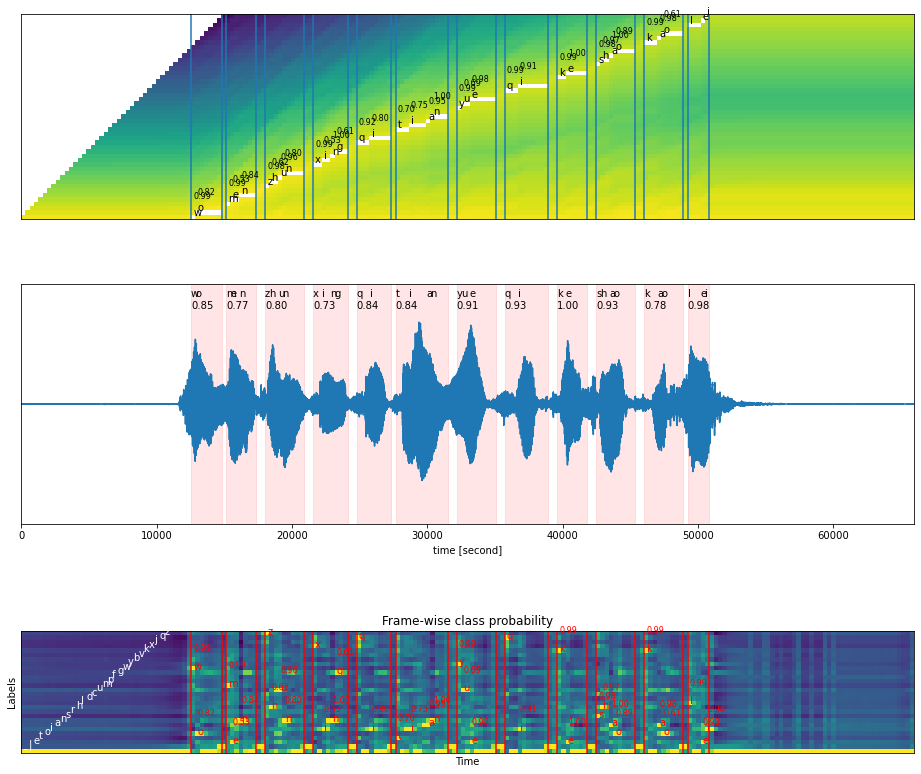

In [98]:
def plot_alignments(trellis, segments, word_segments, waveform):
    trellis_with_path = trellis.clone()
    for i, seg in enumerate(segments):
        if seg.label != "|":
            trellis_with_path[seg.start + 1 : seg.end + 1, i + 1] = float("nan")

    fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(16, 15))

    ax1.imshow(trellis_with_path[1:, 1:].T, origin="lower")
    ax1.set_xticks([])
    ax1.set_yticks([])

    for word in word_segments:
        ax1.axvline(word.start - 0.5)
        ax1.axvline(word.end - 0.5)

    for i, seg in enumerate(segments):
        if seg.label != "|":
            ax1.annotate(seg.label, (seg.start, i + 0.3))
            ax1.annotate(f"{seg.score:.2f}", (seg.start, i + 4), fontsize=8)


    # The original waveform
    ratio = waveform.size(0) / (trellis.size(0) - 1)
    ax2.plot(waveform)
    for word in word_segments:
        x0 = ratio * word.start
        x1 = ratio * word.end
        ax2.axvspan(x0, x1, alpha=0.1, color="red")
        ax2.annotate(f"{word.score:.2f}", (x0, 0.8))

    for seg in segments:
        if seg.label != "|":
            ax2.annotate(seg.label, (seg.start * ratio, 0.9))
    xticks = ax2.get_xticks()
    plt.xticks(xticks, xticks / bundle.sample_rate)
    ax2.set_xlabel("time [second]")
    ax2.set_yticks([])
    ax2.set_ylim(-1.0, 1.0)
    ax2.set_xlim(0, waveform.size(-1))

    ax3.imshow(emission.T, origin="lower")
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax3.set_title("Frame-wise class probability")
    ax3.set_xlabel("Time")
    ax3.set_ylabel("Labels")
    # ax3.set_xlim(0, len(emission))
    for word in word_segments:
        ax3.axvline(word.start - 0.5, color = 'red')
        ax3.axvline(word.end - 0.5, color = 'red')
    for i, seg in enumerate(segments):
        if seg.label != "|":
            id = label2id(seg.label)[0]
            ax3.annotate(seg.label, (seg.start, id -0.3), color='red')
            ax3.annotate(f"{seg.score:.2f}", (seg.start, id + 4), fontsize=8, color='red')
    for i, label in enumerate(labels):
        ax3.annotate(label, (i*1.2, i - 0.3), color='white')


plot_alignments(
    trellis,
    segments,
    word_segments,
    waveform[0],
)
plt.show()

In [99]:
# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
    ratio = waveform.size(1) / (trellis.size(0) - 1)
    word = word_segments[i]
    x0 = int(ratio * word.start)
    x1 = int(ratio * word.end)
    filename = f"_assets/{i}_{word.label}.wav"
    torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
    print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
    return Audio(filename)

In [113]:
# Generate the audio for each segment
print(transcript)
i = 0

wo|men|zhun|xing|qi|tian|yue|qi|ke|shao|kao|lei


In [125]:
display_segment(i)
i+=1

lei (0.98): 3.077 - 3.178 sec
please check ./audio-temp.wav for audio


## Conclusion

In this tutorial, we looked how to use torchaudio’s Wav2Vec2 model to
perform CTC segmentation for forced alignment.


